<a href="https://colab.research.google.com/github/kgaobears/yelp-nlp/blob/main/Yelp_recommendation_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NLP Yelp Rating Prediction

In [ ]:
# %pip install transformers

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import torch
# import transformers
import io
import os
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
import json
import pickle
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# How to Import Data to Google Colab
### The Bonus Method from here: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
In your Google Drive (“My Drive”), create a folder called data in the location of your choosing (do it in My Drive root directory). This is where you will upload your data.
From a Colab notebook, type the following: \
```
from google.colab import drive
drive.mount('/content/drive')
```
Running the commands will bring you to a Google Authentication step. You should see a screen with Google Drive File Stream wants to access your Google Account. After you allow permission, copy the given verification code and paste it in the box in Colab.
In the notebook, click on the charcoal > (for me it's the folder icon) on the top left of the notebook and click on Files. *Locate the data folder you created earlier and find your data*. Right-click on your data and select Copy Path. Store this copied path into a variable and you are ready to go.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Clean texts in json file and save it

In [ ]:
# Reference: https://thedatafrog.com/en/articles/text-preprocessing-machine-learning-yelp/
def process_file(ifname, ofname):
    '''tokenize data in file fname. 
    The output is written to fname_tok.json
    '''
    ifile = open(ifname)
    ofile = open(ofname,'w')
    for i, line in enumerate(ifile):
        if i%1000 == 0:
            print(i) 
        # convert the json on this line to a dict
        data = json.loads(line) 
        # extract the review text
        text = data['text']
        # tokenize
        words = nltk.word_tokenize(text)
        # convert all words to lower case 
        words = [word.lower() for word in words]
        # updating JSON and writing to output file
        data['text'] = words
        line = json.dumps(data)
        ofile.write(line+'\n')
    ifile.close()
    ofile.close()

In [ ]:
# Only need to run once
# i_path = "/content/drive/My Drive/data/yelp_review_training_dataset.jsonl"
# o_path = "/content/drive/My Drive/data/cleaned_data.jsonl"
# process_file(i_path, o_path)

Preprocess the data
- remove unnecessary features ('review_id')
- clean the texts

In [ ]:
data_path = "/content/drive/My Drive/data/cleaned_data.jsonl"
tweets = []
for line in open(data_path, 'r'):
    tweets.append(json.loads(line))

In [ ]:
len(tweets)

533581

In [ ]:
# Divide the data into train and validation sets
df = pd.DataFrame(tweets)
df = df.drop(columns=['review_id'])

In [ ]:
df.head()

,text,stars
0,"[total, bill, for, this, horrible, service, ?,...",1.0
1,"[i, *adore*, travis, at, the, hard, rock, 's, ...",5.0
2,"[i, have, to, say, that, this, office, really,...",5.0
3,"[went, in, for, a, lunch, ., steak, sandwich, ...",5.0
4,"[today, was, my, second, out, of, three, sessi...",1.0


In [ ]:
len(df)

533581

Split train (0.8), val (0.1), and test(0.1) sets.
Used random seed of 1

In [ ]:
df = shuffle(df, random_state=1)
train, validation, test = df.iloc[:int(len(df) * 0.8)], df.iloc[int(len(df) * 0.8) : int(len(df) * 0.9)], df.iloc[int(len(df) * 0.9):]

In [ ]:
train_X, train_y = train['text'], train['stars']
val_X, val_y = validation['text'], validation['stars']
test_X, test_y = test['text'], test['stars']

Convert each text to list of indices of words

In [ ]:
# # Reference: https://towardsdatascience.com/word-embeddings-for-sentiment-analysis-65f42ea5d26e
# tk = Tokenizer(num_words=50000,
#                filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n',
#                lower=True,
#                split=" "
#               )
# tk.fit_on_texts(train_X)

In [ ]:
tk_path='/content/drive/My Drive/data/tokenizer.pickle' #for 50,000 words

In [ ]:
# with open(tk_path, 'wb') as handle:
#     pickle.dump(tk, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(tk_path, 'rb') as handle:
    tk = pickle.load(handle)

In [ ]:
train_X_seq = tk.texts_to_sequences(train_X)
val_X_seq = tk.texts_to_sequences(val_X)
test_X_seq = tk.texts_to_sequences(test_X)

In [ ]:
assert len(train_X_seq) + len(val_X_seq) + len(test_X_seq) == len(df)

Pad each sequence by max length of all sequences

In [ ]:
max_len = -1
for seq in train_X_seq:
  if len(seq) > max_len:
    max_len = len(seq)

for seq in val_X_seq:
  if len(seq) > max_len:
    max_len = len(seq)

for seq in test_X_seq:
  if len(seq) > max_len:
    max_len = len(seq)

In [ ]:
max_len

1164

In [ ]:
train_X_seq = pad_sequences(train_X_seq, maxlen=max_len)
val_X_seq = pad_sequences(val_X_seq, maxlen=max_len)
test_X_seq = pad_sequences(test_X_seq, maxlen=max_len)

One hot encode the labels (maybe not required)

Load pre-trained glove embedding

In [ ]:
glove_path = "/content/drive/My Drive/data/glove.twitter.27B/glove.twitter.27B.200d.txt"

In [ ]:
glove_embedding = {}
glove = open(glove_path)
with open(glove_path, 'r') as f:
  for line in glove:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], dtype='float64')
      glove_embedding[word] = vector

In [ ]:
# glove_embedding

Extract word embedding from glove based on words in our dataset

In [ ]:
#Reference: https://towardsdatascience.com/word-embeddings-for-sentiment-analysis-65f42ea5d26e
emb_matrix = np.zeros((50000, 200))
for w, i in tk.word_index.items():
    if i < 50000:
        vect = glove_embedding.get(w)
        if vect is not None:
          emb_matrix[i] = vect
    else:
        break

Build data generator

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def data_generator(seq, label, batch_size):

    seq = np.array(seq)
    label = to_categorical(label)
    label = label[:, 1:]

    data = np.concatenate((seq, label), axis=1)

    while True:
        
        np.random.shuffle(data)
        X, y = data[:, :-5], data[:, -5:]

        # num_iter = int(len(seq) / batch_size) - 1
        # for i in range(num_iter):
        #   yield [X[batch_size * i : batch_size * (i + 1), :], y[batch_size * i : batch_size * (i + 1)]]

        yield [X[: batch_size, :], y[: batch_size]]

Model 1: LSTM(1024) + Dense

In [ ]:
model = models.Sequential()
model.add(layers.Embedding(50000, 200, input_length=max_len))
model.add(layers.Dropout(0.5))
model.add(layers.LSTM(1024, dropout=0.3, recurrent_dropout=0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

Freeze the embedding layer of the model

In [ ]:
model.layers[0].set_weights([emb_matrix])
model.layers[0].trainable = False

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1164, 200)         10000000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1164, 200)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024)              5017600   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 15,281,285
Trainable params: 5,281,285
Non-trainable params: 10,000,000
_________________________________________________________________


In [ ]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=5e-4),
              metrics=['acc'])

In [ ]:
epoch = 12
batch_size = 128
steps = len(train_X_seq) // batch_size

In [ ]:
# Due to the runtime limit of colab, had to run each epoch at a time
# Restore from previous epoch
model_path = "/content/drive/My Drive/data/trained_models/"
model.load_weights(model_path + 'epoch_11.h5')
trace = \
  [{'acc': [0.6823823],
    'loss': [0.8391055307330382],
    'val_acc': [0.7478749752044678],
    'val_loss': [0.5470333695411682]},
  {'acc': [0.7272069],
    'loss': [0.7043180210403003],
    'val_acc': [0.7578281164169312],
    'val_loss': [0.5354262590408325]},
  {'acc': [0.7431904],
    'loss': [0.6548993458058495],
    'val_acc': [0.7640312314033508],
    'val_loss': [0.4882242679595947]},
  {'acc': [0.7560574],
    'loss': [0.6162402497288275],
    'val_acc': [0.7718906402587891],
    'val_loss': [0.5270772576332092]},
  {'acc': [0.7646807],
    'loss': [0.5959780901026854],
    'val_acc': [0.7754843831062317],
    'val_loss': [0.40212321281433105]},
  {'acc': [0.7681276],
    'loss': [0.5884306511892554],
    'val_acc': [0.7795624732971191],
    'val_loss': [0.6955069303512573]},
  {'acc': [0.769011],
    'loss': [0.5901212350705032],
    'val_acc': [0.774093747138977],
    'val_loss': [0.6051162481307983]},
  {'acc': [0.7706021],
    'loss': [0.5848249332341307],
    'val_acc': [0.7745781540870667],
    'val_loss': [0.5339535474777222]},
  {'acc': [0.7707],
   'loss': [0.5828],
   'val_acc': [0.781],
   'val_loss': [0.4357]},
  {'acc': [0.777],
   'loss': [0.5666],
   'val_acc': [0.7847],
   'val_loss': [0.6317]},
  {'acc': [0.77630335],
    'loss': [0.5682157798931137],
    'val_acc': [0.7851406335830688],
    'val_loss': [0.4277696907520294]},
  {'acc': [0.7795394],
    'loss': [0.5614399272271381],
    'val_acc': [0.7819374799728394],
    'val_loss': [0.6129763722419739]}]

In [ ]:
# # trace = []
for i in range(10, epoch):
    print(i)
    train_generator = data_generator(train_X_seq, train_y, batch_size)
    val_generator = data_generator(val_X_seq, val_y, batch_size)
    history = model.fit_generator(train_generator,
                                  epochs=1,
                                  steps_per_epoch=steps,
                                  validation_data=val_generator,
                                  validation_steps=500,
                                  verbose=1)
    trace.append(history.history)
    model.save(model_path + 'LSTM/epoch_' + str(i) + '.h5')

In [ ]:
num_epochs = len(trace)
acc, loss, val_acc, val_loss = [], [], [], []
for i in range(num_epochs):
    acc.append(trace[i]['acc'])
    loss.append(trace[i]['loss'])
    val_acc.append(trace[i]['val_acc'])
    val_loss.append(trace[i]['val_loss'])

In [ ]:
x = [i for i in range(num_epochs)]

''

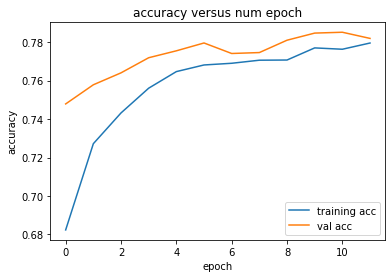

In [ ]:
plt.plot(x, acc)
plt.plot(x, val_acc)
plt.title('accuracy versus num epoch')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training acc', 'val acc'])
;

''

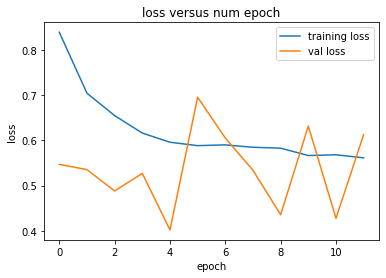

In [ ]:
plt.plot(x, loss)
plt.plot(x, val_loss)
plt.title('loss versus num epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'val loss'])
;

In [ ]:
model_path = "/content/drive/My Drive/data/trained_models/"
model.load_weights(model_path + 'LSTM/epoch_11.h5')

In [ ]:
# measure validation accuracy
val_loss, val_acc = model.evaluate_generator(data_generator(val_X_seq, val_y, batch_size), steps=100)

In [ ]:
val_loss

0.5571508407592773

In [ ]:
val_acc

0.7837499976158142

In [ ]:
# measure test accuracy
test_loss, test_acc = model.evaluate_generator(data_generator(test_X_seq, test_y, batch_size), steps=100)

In [ ]:
test_loss

0.7308070659637451

In [ ]:
test_acc

0.7835937738418579

In [ ]:
output = model.predict(val_X_seq[:10, :])

In [ ]:
np.argmax(output, axis=1) + 1.0

array([1., 5., 1., 5., 2., 5., 3., 5., 3., 5.])

In [ ]:
# def initialize_tokenizer():
# 	tk_path = '/content/drive/My Drive/data/tokenizer.pickle'
# 	with open(tk_path, 'rb') as handle:
# 	    tk = pickle.load(handle)
# 	print('Initialized Tokenizer')
# 	return tk

# def load_model():

# 	model = models.Sequential()
# 	model.add(layers.Embedding(50000, 200, input_length=1164)) #input_length=max_len
# 	model.add(layers.Dropout(0.5))
# 	model.add(layers.LSTM(1024, dropout=0.3, recurrent_dropout=0.3))
# 	model.add(layers.Dense(256, activation='relu'))
# 	model.add(layers.Dense(5, activation='softmax'))	
# 	# model.compile(loss='categorical_crossentropy',
# 	#               optimizer=optimizers.RMSprop(lr=5e-4),
# 	#               metrics=['acc'])

# 	model_path = "/content/drive/My Drive/data/trained_models/epoch_11.h5"
# 	model.load_weights(model_path)
# 	print('Loaded Model')
# 	return model

# def eval(text, tk, model):

#   # print(text)
#   # tmp = tk.texts_to_sequences(text)
#   # seq = []
#   # for word in tmp:
#   #   seq.append(tmp[0] if len(tmp) > 0 else 0)

#   seq = tk.texts_to_sequences([text])

#   # print(seq)

#   seq = pad_sequences(seq, maxlen=1164)

#   # print(seq)

#   # print(model.predict(seq))

#   # print(np.argmax(model.predict(seq)) + 1.0)

#   return np.argmax(model.predict(seq)) + 1.0 #axis=1 if processing multiple texts a time

In [ ]:
# validation_file = "/content/drive/My Drive/data/challenge5/yelp_challenge_5_with_answers.jsonl"

In [ ]:
# tk = initialize_tokenizer()
# model = load_model()

# with open("/content/drive/My Drive/data/challenge5/output.jsonl", "w") as fw:
#   with open(validation_file, "r") as fr:
#     for line in fr:
#       review = json.loads(line)
#       fw.write(json.dumps({"review_id": review['review_id'], "predicted_stars": eval(review['text'], tk, model)})+"\n")

Initialized Tokenizer
Loaded Model


Model 2: Conv1D + Dense

In [ ]:
model = models.Sequential()
model.add(layers.Embedding(50000, 200, input_length=max_len))

model.add(layers.Conv1D(256, 5, padding='same', activation='relu'))
model.add(layers.Conv1D(512, 5, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(stride=2))

model.add(layers.Conv1D(1024, 5, padding='same', activation='relu'))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(strides=2)`
  


In [ ]:
model.layers[0].set_weights([emb_matrix])
model.layers[0].trainable = False

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1164, 200)         10000000  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1164, 256)         256256    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1164, 512)         655872    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 582, 512)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 582, 1024)         2622464   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)              

In [ ]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=5e-4),
              metrics=['acc'])

In [ ]:
# epoch = 12
batch_size = 128
steps = len(train_X_seq) // batch_size

In [ ]:
# Due to the runtime limit of colab, had to run each epoch at a time
# Restore from previous epoch
model_path = "/content/drive/My Drive/data/trained_models/"
model.load_weights(model_path + 'conv1d/epoch_9.h5')
trace = \
  [{'acc': [0.74457294],
    'loss': [0.6532391668188408],
    'val_acc': [0.7593125104904175],
    'val_loss': [0.5915010571479797]},
  {'acc': [0.78199047],
    'loss': [0.5520513805359083],
    'val_acc': [0.7790781259536743],
    'val_loss': [0.6340680122375488]},
  {'acc': [0.79026693],
    'loss': [0.5316256266031425],
    'val_acc': [0.7721874713897705],
    'val_loss': [0.6757320165634155]},
  {'acc': [0.79226345],
    'loss': [0.527761304546561],
    'val_acc': [0.7612031102180481],
    'val_loss': [0.5371536016464233]},
  {'acc': [0.7957151],
    'loss': [0.519927030884011],
    'val_acc': [0.7631875276565552],
    'val_loss': [0.6736571788787842]},
  {'acc': [0.797735],
    'loss': [0.5144338964897498],
    'val_acc': [0.7557812333106995],
    'val_loss': [0.6181401014328003]},
  {'acc': [0.7992511],
    'loss': [0.5138116710974059],
    'val_acc': [0.7776093482971191],
    'val_loss': [0.5601906180381775]},
  {'acc': [0.801182],
    'loss': [0.5171483094794491],
    'val_acc': [0.772781252861023],
    'val_loss': [0.577178955078125]},
  {'acc': [0.8043407],
    'loss': [0.49665852857336856],
    'val_acc': [0.7739218473434448],
    'val_loss': [0.578159511089325]},
  {'acc': [0.8074221],
    'loss': [0.4906259973158576],
    'val_acc': [0.7779218554496765],
    'val_loss': [0.5228006839752197]}]

In [ ]:
# for i in range(10, 10):
#     print(i)
#     train_generator = data_generator(train_X_seq, train_y, batch_size)
#     val_generator = data_generator(val_X_seq, val_y, batch_size)
#     history = model.fit_generator(train_generator,
#                                   epochs=1,4
#                                   steps_per_epoch=steps,
#                                   validation_data=val_generator,
#                                   validation_steps=500,
#                                   verbose=1)
#     trace.append(history.history)
#     model.save(model_path + 'conv1d/epoch_' + str(i) + '.h5')

7
Epoch 1/1
3334/3334 [==============================] - 4272s 1s/step - loss: 0.5171 - acc: 0.8012 - val_loss: 0.5772 - val_acc: 0.7728
8
Epoch 1/1
3334/3334 [==============================] - 4276s 1s/step - loss: 0.4967 - acc: 0.8043 - val_loss: 0.5782 - val_acc: 0.7739
9
Epoch 1/1
3334/3334 [==============================] - 4263s 1s/step - loss: 0.4906 - acc: 0.8074 - val_loss: 0.5228 - val_acc: 0.7779


In [ ]:
num_epochs = len(trace)
acc, loss, val_acc, val_loss = [], [], [], []
for i in range(num_epochs):
    acc.append(trace[i]['acc'])
    loss.append(trace[i]['loss'])
    val_acc.append(trace[i]['val_acc'])
    val_loss.append(trace[i]['val_loss'])

In [ ]:
x = [i for i in range(num_epochs)]

''

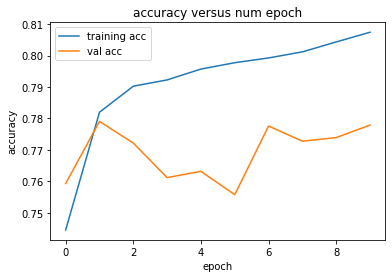

In [ ]:
plt.plot(x, acc)
plt.plot(x, val_acc)
plt.title('accuracy versus num epoch')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training acc', 'val acc'])
;

''

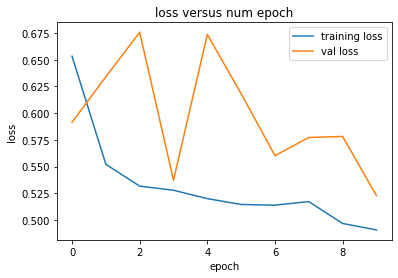

In [ ]:
plt.plot(x, loss)
plt.plot(x, val_loss)
plt.title('loss versus num epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'val loss'])
;

In [ ]:
model_path = "/content/drive/My Drive/data/trained_models/"
model.load_weights(model_path + 'conv1d/epoch_9.h5')

In [ ]:
# measure validation accuracy
val_loss, val_acc = model.evaluate_generator(data_generator(val_X_seq, val_y, batch_size), steps=100)

In [ ]:
val_loss

0.7731531858444214

In [ ]:
val_acc

0.7720312476158142

In [ ]:
# measure test accuracy
test_loss, test_acc = model.evaluate_generator(data_generator(test_X_seq, test_y, batch_size), steps=100)

In [ ]:
test_loss

0.5418553352355957

In [ ]:
test_acc

0.77734375

Model 3: GRU

In [ ]:
model = models.Sequential()
model.add(layers.Embedding(50000, 200, input_length=max_len))
model.add(layers.GRU(256))
model.add(layers.Dense(256, activation='tanh'))
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(5, activation='softmax'))

Freeze the embedding layer of the model

In [ ]:
model.layers[0].set_weights([emb_matrix])
model.layers[0].trainable = False

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1164, 200)         10000000  
_________________________________________________________________
gru_3 (GRU)                  (None, 256)               350976    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 645       
Total params: 10,450,309
Trainable params: 450,309
Non-trainable params: 10,000,000
_________________________________________________________________


In [ ]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=5e-4),
              metrics=['acc'])

In [ ]:
epoch = 12
batch_size = 128
steps = len(train_X_seq) // batch_size

In [ ]:
# Due to the runtime limit of colab, had to run each epoch at a time
# Restore from previous epoch
model_path = "/content/drive/My Drive/data/trained_models/"
model.load_weights(model_path + 'GRU/epoch_2.h5')
trace = \
  [{'acc': [0.7429936],
    'loss': [0.654380567242231],
    'val_acc': [0.7605624794960022],
    'val_loss': [0.5554561614990234]},
  {'acc': [0.77212524],
    'loss': [0.57214564508711],
    'val_acc': [0.7685468792915344],
    'val_loss': [0.6560267210006714]},
  {'acc': [0.7864076],
    'loss': [0.5335325640014495],
    'val_acc': [0.7787187695503235],
    'val_loss': [0.44128021597862244]}]

In [ ]:
for i in range(3, 4):
    print(i)
    train_generator = data_generator(train_X_seq, train_y, batch_size)
    val_generator = data_generator(val_X_seq, val_y, batch_size)
    history = model.fit_generator(train_generator,
                                  epochs=1,
                                  steps_per_epoch=steps,
                                  validation_data=val_generator,
                                  validation_steps=500,
                                  verbose=1)
    trace.append(history.history)
    model.save(model_path + 'GRU/epoch_' + str(i) + '.h5')

3
Epoch 1/1
 476/3334 [===>..........................] - ETA: 2:52:29 - loss: 0.5131 - acc: 0.7946

In [ ]:
trace

[{'acc': [0.7429936],
  'loss': [0.654380567242231],
  'val_acc': [0.7605624794960022],
  'val_loss': [0.5554561614990234]},
 {'acc': [0.77212524],
  'loss': [0.57214564508711],
  'val_acc': [0.7685468792915344],
  'val_loss': [0.6560267210006714]},
 {'acc': [0.7864076],
  'loss': [0.5335325640014495],
  'val_acc': [0.7787187695503235],
  'val_loss': [0.44128021597862244]}]

In [ ]:
num_epochs = len(trace)
acc, loss, val_acc, val_loss = [], [], [], []
for i in range(num_epochs):
    acc.append(trace[i]['acc'])
    loss.append(trace[i]['loss'])
    val_acc.append(trace[i]['val_acc'])
    val_loss.append(trace[i]['val_loss'])

In [ ]:
x = [i for i in range(num_epochs)]

''

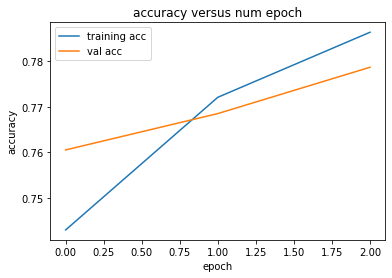

In [ ]:
plt.plot(x, acc)
plt.plot(x, val_acc)
plt.title('accuracy versus num epoch')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training acc', 'val acc'])
;

''

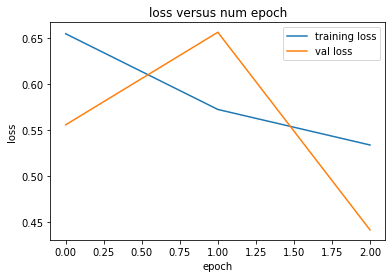

In [ ]:
plt.plot(x, loss)
plt.plot(x, val_loss)
plt.title('loss versus num epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training loss', 'val loss'])
;

In [ ]:
model_path = "/content/drive/My Drive/data/trained_models/"
model.load_weights(model_path + 'GRU/epoch_2.h5')

In [ ]:
# measure validation accuracy
val_loss, val_acc = model.evaluate_generator(data_generator(val_X_seq, val_y, batch_size), steps=100)

In [ ]:
val_loss

0.5817391872406006

In [ ]:
val_acc

0.7786718606948853

In [ ]:
# measure test accuracy
test_loss, test_acc = model.evaluate_generator(data_generator(test_X_seq, test_y, batch_size), steps=100)

In [ ]:
test_loss

0.45198923349380493

In [ ]:
test_acc

0.7755468487739563

Model 4: AdaBoost (data: one hot encoding of 5000 most frequent words)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [ ]:
train_X_matrix = tk.texts_to_matrix(train_X)
val_X_matrix = tk.texts_to_matrix(val_X)
test_X_matrix = tk.texts_to_matrix(test_X)

In [ ]:
np.max(test_X_matrix[0])

1.0

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [ ]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)

In [ ]:
clf.fit(train_X_matrix, train_y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [ ]:
# model_path = "/content/drive/My Drive/data/trained_models/"
# filename = 'AdaBoost/adaboost_onehot.sav'
# pickle.dump(clf, open(model_path + filename, 'wb'))

In [ ]:
model_path = "/content/drive/My Drive/data/trained_models/"
filename = 'AdaBoost/adaboost_onehot.sav'
clf = pickle.load(open(model_path + filename, 'rb'))

In [ ]:
val_acc = accuracy_score(val_y, clf.predict(val_X_matrix))

In [ ]:
val_acc

0.7051613628696728

In [ ]:
test_acc = accuracy_score(test_y, clf.predict(test_X_matrix))

In [ ]:
test_acc

0.7040049476189584

Model 5: AdaBoost (data: word count of 5000 most frequent words)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [ ]:
train_X_matrix = tk.texts_to_matrix(train_X, mode='count')
val_X_matrix = tk.texts_to_matrix(val_X, mode='count')
test_X_matrix = tk.texts_to_matrix(test_X, mode='count')

In [ ]:
np.sum(train_X_matrix[0])

104.0

In [ ]:
np.max(train_X_matrix[0])

12.0

In [ ]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)

In [ ]:
clf.fit(train_X_matrix, train_y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

In [ ]:
model_path = "/content/drive/My Drive/data/trained_models/"
filename = 'AdaBoost/adaboost_wordcounts.sav'
pickle.dump(clf, open(model_path + filename, 'wb'))

In [ ]:
# model_path = "/content/drive/My Drive/data/trained_models/"
# filename = 'AdaBoost/adaboost_wordcounts.sav'
# clf = pickle.load(open(model_path + filename, 'rb'))

In [ ]:
val_acc = accuracy_score(val_y, clf.predict(val_X_matrix))

In [ ]:
val_acc

0.7023689043817235

In [ ]:
test_acc = accuracy_score(test_y, clf.predict(test_X_matrix))

In [ ]:
test_acc

0.7031053805356172

Model 6: SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [ ]:
train_X_matrix = tk.texts_to_matrix(train_X)
val_X_matrix = tk.texts_to_matrix(val_X)
test_X_matrix = tk.texts_to_matrix(test_X)

In [ ]:
np.max(train_X_matrix[0])

1.0

In [ ]:
clf = LinearSVC(random_state=1)

In [ ]:
clf.fit(train_X_matrix, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [ ]:
# model_path = "/content/drive/My Drive/data/trained_models/"
# filename = 'SVM/SVM.sav'
# pickle.dump(clf, open(model_path + filename, 'wb'))

In [ ]:
model_path = "/content/drive/My Drive/data/trained_models/"
filename = 'SVM/SVM.sav'
clf = pickle.load(open(model_path + filename, 'rb'))

In [ ]:
val_acc = accuracy_score(val_y, clf.predict(val_X_matrix))

In [ ]:
val_acc

0.7535889651036396

In [ ]:
test_acc = accuracy_score(test_y, clf.predict(test_X_matrix))

In [ ]:
test_acc

0.7531063175846624

Model 7: Bert Model

In [ ]:
#https://towardsdatascience.com/bert-text-classification-in-3-lines-of-code-using-keras-264db7e7a358

In [ ]:
# To preprocess data

# import json
# import pandas as pd
# from sklearn.utils import shuffle
# from tqdm import tqdm
# import numpy as np

# import io
# import os

# data_path = "yelp_review_training_dataset.jsonl"
# tweets = []
# for line in open(data_path, 'r'):
#     tweets.append(json.loads(line))

# df = pd.DataFrame(tweets)
# df = df.drop(columns=['review_id'])

# df = shuffle(df, random_state=1)
# train, validation, test = df.iloc[:int(len(df) * 0.8)], df.iloc[int(len(df) * 0.8) : int(len(df) * 0.9)], df.iloc[int(len(df) * 0.9):]

# def preprocess_bert(dataset, out_path):
# 	for i in tqdm(range(len(dataset))):
# 		with open(out_path + str(i) + '.txt', 'w+') as f:
# 			f.write(dataset[i][0])

# # Divide training set
# for num_class in range(1, 6):
# 	print(num_class)
# 	path = 'bert_data/train/' + str(num_class) + '/'
# 	preprocess_bert(np.array(train.query("stars == " + str(float(num_class)))), path)

# # Divide val set
# for num_class in range(1, 6):
# 	print(num_class)
# 	path = 'bert_data/val/' + str(num_class) + '/'
# 	preprocess_bert(np.array(validation.query("stars == " + str(float(num_class)))), path)

# # Divide test set
# for num_class in range(1, 6):
# 	print(num_class)
# 	path = 'bert_data/test/' + str(num_class) + '/'
# 	preprocess_bert(np.array(test.query("stars == " + str(float(num_class)))), path)

In [ ]:
# To train Bert model

(X_train, y_train), (X_val, y_val), preproc = text.texts_from_folder('bert_data', maxlen=5, 
                                                                      preprocess_mode='bert',
                                                                      train_test_names=['train', 'val'],
                                                                      classes=['1', '2', '3', '4', '5'])

print('data ready')

model = text.text_classifier('bert', train_data=(X_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(X_train, y_train), batch_size=6)

print('model ready')

learner.fit_onecycle(2e-5, 1)

predictor = ktrain.get_predictor(learner.model, preproc)
predictor.save('bert_model_epoch_1')

In [ ]:
# reload the predictor
reloaded_predictor = ktrain.load_predictor('/tmp/my_predictor')
# make a prediction on the same document to verify it still works
reloaded_predictor.predict(test_b.data[0:1])


val = learner.validate(val_data=(X_val, y_val), class_names=['1', '2', '3', '4', '5'])

Model 8: Ensemble

In [ ]:
model_path = "/content/drive/My Drive/data/trained_models/"

In [ ]:
# LSTM
model_1 = models.Sequential()
model_1.add(layers.Embedding(50000, 200, input_length=max_len))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.LSTM(1024, dropout=0.3, recurrent_dropout=0.3))
model_1.add(layers.Dense(256, activation='relu'))
model_1.add(layers.Dense(5, activation='softmax'))

model_1.load_weights(model_path + 'LSTM/epoch_11.h5')

In [ ]:
pred = model_1.predict(test_X_seq)

In [ ]:
pred = np.argmax(pred, axis=1) + 1

In [ ]:
np.sum(pred == test_y) / len(pred)

0.7838602672463877

In [ ]:
pred = pred.reshape((-1, 1))

In [ ]:
# np.savetxt(model_path + 'ensemble_pred.csv', pred, delimiter=',')

In [ ]:
# pred = np.genfromtxt(model_path + 'ensemble_pred.csv', delimiter=',')

In [ ]:
# Conv1D
model_2 = models.Sequential()
model_2.add(layers.Embedding(50000, 200, input_length=max_len))

model_2.add(layers.Conv1D(256, 5, padding='same', activation='relu'))
model_2.add(layers.Conv1D(512, 5, padding='same', activation='relu'))
model_2.add(layers.MaxPooling1D(stride=2))

model_2.add(layers.Conv1D(1024, 5, padding='same', activation='relu'))
model_2.add(layers.GlobalMaxPooling1D())

model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dense(128, activation='relu'))
model_2.add(layers.Dense(5, activation='softmax'))

model_2.load_weights(model_path + 'conv1d/epoch_9.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(strides=2)`
  


In [ ]:
tmp = model_2.predict(test_X_seq)

In [ ]:
tmp = np.argmax(tmp, axis=1) + 1

In [ ]:
np.sum(tmp == test_y) / len(tmp)

0.7766824715605615

In [ ]:
tmp = tmp.reshape((-1, 1))

In [ ]:
pred = np.concatenate((pred, tmp), axis=1)

In [ ]:
# np.savetxt(model_path + 'ensemble_pred.csv', pred, delimiter=',')

In [ ]:
# pred = np.genfromtxt(model_path + 'ensemble_pred.csv', delimiter=',')

In [ ]:
# GRU
model_3 = models.Sequential()
model_3.add(layers.Embedding(50000, 200, input_length=max_len))
model_3.add(layers.GRU(256))
model_3.add(layers.Dense(256, activation='tanh'))
model_3.add(layers.Dense(128, activation='tanh'))
model_3.add(layers.Dense(5, activation='softmax'))

model_3.load_weights(model_path + 'GRU/epoch_2.h5')

In [ ]:
tmp = model_3.predict(test_X_seq)

In [ ]:
tmp = np.argmax(tmp, axis=1) + 1

In [ ]:
np.sum(tmp == test_y) / len(tmp)

0.7791187990779438

In [ ]:
tmp = tmp.reshape((-1, 1))

In [ ]:
pred = np.concatenate((pred, tmp), axis=1)

In [ ]:
# np.savetxt(model_path + 'ensemble_nn_pred.csv', pred, delimiter=',')

In [ ]:
pred = np.genfromtxt(model_path + 'ensemble_pred.csv', delimiter=',')

In [ ]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier

filename = 'AdaBoost/adaboost_onehot.sav'
model_4 = pickle.load(open(model_path + filename, 'rb'))

In [ ]:
test_X_matrix = tk.texts_to_matrix(test_X, mode='count')

In [ ]:
tmp = model_4.predict(test_X_matrix)

In [ ]:
tmp = tmp.reshape((-1, 1))

In [ ]:
pred = np.concatenate((pred, tmp), axis=1)

In [ ]:
# SVM
from sklearn.svm import LinearSVC

filename = 'SVM/SVM.sav'
model_5 = pickle.load(open(model_path + filename, 'rb'))

In [ ]:
test_X_matrix = tk.texts_to_matrix(test_X, mode='count')

In [ ]:
tmp = model_5.predict(test_X_matrix)

In [ ]:
np.sum(tmp == test_y) / len(tmp)

0.7349275661088102

In [ ]:
pred = np.concatenate((pred, tmp), axis=1)

In [ ]:
# np.savetxt(model_path + 'total_ensemble_pred.csv', pred, delimiter=',')

In [ ]:
pred = np.genfromtxt(model_path + 'ensemble_pred.csv', delimiter=',')

In [ ]:
# Test accuracy of each model before ensembling
for i in range(5):
    print('model ' + str(i) + ': ' + str(np.sum(pred[:,i] == test_y) / len(tmp)))

model 0: 0.7838602672463877
model 1: 0.7766824715605615
model 2: 0.7791187990779438
model 3: 0.7040049476189584
model 4: 0.7349275661088102


In [ ]:
ensemble_1 = np.round(np.mean(pred, axis=1))
print('ensemble_1: ' + str(np.sum(ensemble_1 == test_y) / len(ensemble_1)))

ensemble_1: 0.741561873348451


In [ ]:
from scipy.stats import mode as mode
ensemble_2 = np.array(mode(pred, axis=1))[0].reshape(-1)
print('ensemble_2: ' + str(np.sum(ensemble_2 == test_y) / len(ensemble_2)))

ensemble_2: 0.7865027455537023


In [ ]:
# ensemble_3 = np.min(pred, axis=1)
# print('ensemble_3: ' + str(np.sum(ensemble_3 == test_y) / len(ensemble_3)))

ensemble_3: 0.7314792256226691
